# Modeling: Home Credit Default Risk
### Spencer Owens
### 5/1/2023

## Table of Contents
<a href='#1'>1. Introduction</a>
<br><a href='#2'>2. Setup</a>
<br><a href='#3'>3. Read in Data</a>
<br><a href='#4'>4. Missing Data</a>
<br><a href='#5'>5. Encoding</a>
<br><a href='#6'>6. Model Fitting</a>
<br><a href='#7'>7. Baseline Model</a>
<br><a href='#8'>8. Feature Engineering</a>
<br> - <a href='#8-1'>8.1 Adding previous loans from Bureau Data</a>
<br> - <a href='#8-2'>8.2 Adding DAYS_CREDIT from Bureau Data</a>
<br> - <a href='#8-3'>8.3 Adding Credit Card Balance Data</a>
<br> - <a href='#8-4'>8.4 Manual Features</a>
<br><a href='#9'>9. LightGB Model</a>


# <a id='1'>1. Intro</a>

This notebook is an analysis of Home Credit's Default Risk problem on Kaggle using machine learning techniques. 

# <a id='2'>2. Setup</a>

In [75]:
! pip install lightgbm

In [76]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import time

# import sklearn packages for modeling
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import gc
import lightgbm as lgb

In [77]:
path = '../CapstoneProject/home-credit-default-risk/'

# <a id='3'>3. Read in Data</a>

In [78]:
# Training data
app_train = pd.read_csv(path + 'application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
# Testing data features
app_test = pd.read_csv(path + 'application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# <a id='4'>4. Missing Data</a>

In [80]:
# function to find missing values in datafame so we can reuse if we look at other data sources
# including proper docstring
def missing_values_table(df):
        
        # sum of missing values
        mis_val = df.isnull().sum()
        
        # % of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # concat table
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% Missing Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0
                                                             ].sort_values('% Missing Values', ascending=False).round(1)
        
        # Print some summary information
        print ("The dataframe has {} columns.\n".format(str(df.shape[1])),      
                "There are {} columns that have missing values.\n".format(str(mis_val_table_ren_columns.shape[0])),
               "There are {} columns that have no missing values".format(int(df.shape[1]) - int(mis_val_table_ren_columns.shape[0])) )
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    

In [81]:
missing_values_table(app_train)

The dataframe has 122 columns.
 There are 67 columns that have missing values.
 There are 55 columns that have no missing values


,Missing Values,% Missing Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


In [82]:
# create dict object from columns and datatypes
columns = app_train.columns.to_series().groupby(app_train.dtypes).groups
for key in columns.keys():
    print('\nData Type {} Columns:'.format(key))
    pprint(list(columns[key]))


Data Type int64 Columns:
['SK_ID_CURR',
 'TARGET',
 'CNT_CHILDREN',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

Data Type float64 Columns:
['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',


We can now observe the distribution of data types across the columns. A notable finding is that many columns contain integers or floating-point numbers, whereas there are relatively few object or string columns. Upon closer inspection of the column names, we can see that several of the integer columns are actually binary encoded "FLAG" variables, taking on values of either 0 or 1. This implies that they are categorical variables, which are already suitable for machine learning purposes. To use the data with various ML algorithms that we plan to explore later in the workbook, we will need to transform the dataset into a matrix of numerical values.

Additionally, we observe that there are numerous floating-point columns containing both customer information and derived summary statistics (e.g., averages, modes). These variables may require scaling to prevent overemphasizing variables with high values.

# <a id='5'>5. Encoding</a>

In [83]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            print("{} was encoded".format(col))
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

NAME_CONTRACT_TYPE was encoded
FLAG_OWN_CAR was encoded
FLAG_OWN_REALTY was encoded
3 columns were label encoded.


In [84]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels
print('Aligned Training Features shape: ', app_train.shape)
print('Aligned Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)
Aligned Training Features shape:  (307511, 240)
Aligned Testing Features shape:  (48744, 239)


# <a id='6'>6. Model Fitting</a>

Prior to conducting any feature engineering, let's perform cross-validation on the training set. This will allow us to establish benchmark accuracy metrics for different models and assist us in identifying the models that perform well with the given data.

During the exploratory data analysis (EDA) phase, we have already encoded our training and test data. However, before proceeding with the cross-validation step, there is one additional task we need to accomplish: scaling the numeric variables. This is essential to ensure that features with large values do not receive disproportionate weight in certain machine learning algorithms. By scaling the numeric quantities, we create a more balanced representation of the data for accurate model evaluation and comparison.

In [85]:
# create X_train, y_train
X_train = app_train.drop('TARGET', axis = 1)
y_train = app_train['TARGET']
X_test = app_test

X_train = X_train.drop('SK_ID_CURR', axis = 1)
X_test = X_test.drop('SK_ID_CURR', axis = 1)

# Feature names
features = list(X_train.columns)

In [86]:
# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(X_train)

# Transform both training and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Repeat with the scaler
scaler.fit(X_train)
train = scaler.transform(X_train)
test = scaler.transform(X_test)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (307511, 238)
Testing data shape:  (48744, 238)


In [87]:
# Using Cross Validation to find a good model
num_folds = 5
seed = 1
scoring = 'roc_auc'
models = []

# Typical Classifiers
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))

# iterate over models and print cross val scores
results = []
names = []
print('Please wait while models train..')
for name, model in models:
    
    # start timer
    start = time.time()
    
    # Cross Validation
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle = True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    
    # stop timing
    end = time.time()
    time_run = (end - start)/60
    output = "{}--> auroc: {}   (Training Time: {}mins)".format(name, cv_results.mean(), time_run)
    
    print(output)


Upon analyzing the evaluation metric and training time, we observe that Random Forest performs the best as measured using roc_auc; we use this metric as opposed to F1 or another accuracy measure because this data contains a skewed amount positive and negative data in the target variable. 

As we proceed with our solution, our objective is to develop a more optimized model. Opting for a more complex model like Random Forest would provide us with greater flexibility for training hyperparameters, if we should so choose. While there are other effective algorithms worth exploring, they may be too intricate to cover in this initial notebook or require extensive training time due to the size of the dataset.

So, for our baseline model, I will proceed with implementing a Random Forest model.

# <a id='7'>7. Baseline Model</a>

In [88]:
# Train LR Model
RF = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
RF.fit(X_train,y_train)

# Extract feature importances
feature_importance_values = RF.feature_importances_
feature_importances = pd.DataFrame({'Feature': features, 'Importance': feature_importance_values})

# Make predictions on the test data
predictions = RF.predict_proba(test)[:, 1]

# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline.csv', index = False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   40.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


When we submit our csv, we get a score of 0.63316 public and 0.64165 private. Not bad for a baseline!

The baseline model demonstrates a satisfactory performance. Nevertheless, this serves as a starting point from which we can further enhance and refine the model by pursuing the following steps:

-Enriching the dataset with additional data to provide more comprehensive information (Adding Features).
-Employing feature engineering techniques to derive new meaningful features from the existing data.
-Exploring more advanced machine learning and deep learning models that incorporate cutting-edge methodologies.
By undertaking these measures, we aim to build upon the initial model and achieve significant improvements in its predictive capabilities and overall effectiveness.








# <a id='8'>8. Feature Engineering</a>

## <a id='8-1'>8.1 Adding previous loans from Bureau Data</a>

<Figure size 1000x1600 with 0 Axes>

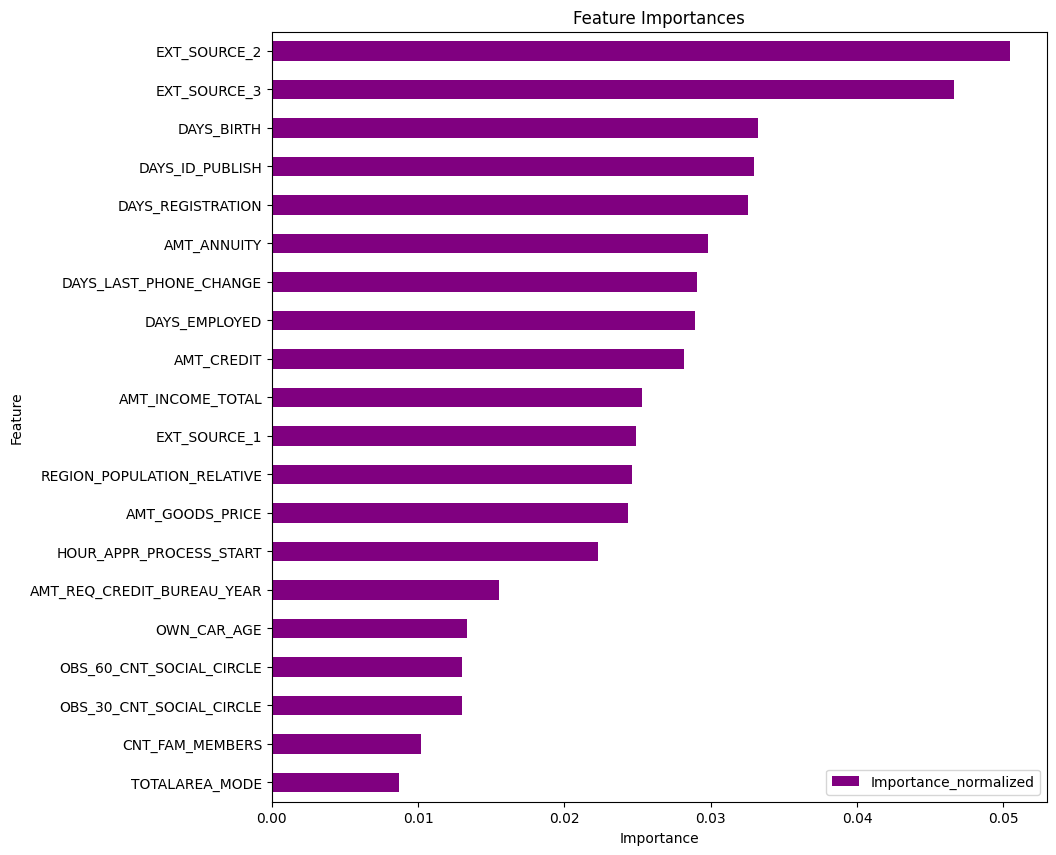

In [89]:
# Function to plot feature importance
def plot_feature_importance(df):

    # Normalize the feature importances to add up to one
    df['Importance_normalized'] = df['Importance'] / df['Importance'].sum()
    df = df.sort_values('Importance_normalized', ascending = True).tail(20)

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 16))

    ax = df.plot(x = 'Feature' , y = 'Importance_normalized', kind = 'barh', figsize=(10,10), color = 'purple')
    
    # Plot labeling
    plt.xlabel('Importance')
    plt.title('Feature Importances')
    plt.show()
    
    # return top 20 features
    return(df['Feature'])

top20 = plot_feature_importance(feature_importances)

In [90]:
# import bureau data
bureau = pd.read_csv(path + "bureau.csv")
bureau.head()


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [91]:
# create feature dataframe
bureau_agg = bureau['SK_ID_CURR'].unique()
bureau_agg = pd.DataFrame(bureau_agg, columns = ['SK_ID_CURR'])
bureau_agg.head()

,SK_ID_CURR
0,215354
1,162297
2,402440
3,238881
4,222183


In [92]:
# previous loan count
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

bureau_agg = bureau_agg.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')
bureau_agg.head()

,SK_ID_CURR,previous_loan_counts
0,215354,11
1,162297,6
2,402440,1
3,238881,8
4,222183,8


In [93]:
# active loan count
active_loan_counts = bureau[bureau['CREDIT_ACTIVE'] == 'Active'].groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'active_loan_counts'})
active_loan_counts.head()

# join new features
bureau_agg = bureau_agg.merge(active_loan_counts, on = 'SK_ID_CURR', how = 'left')

# fill na
bureau_agg = bureau_agg.fillna(0)

In [94]:
# join additional features onto train and test
app_train_features = app_train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
app_test_features = app_test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
app_train_features = app_train_features.fillna(0)
app_test_features = app_test_features.fillna(0)

In [95]:
# Create function for plotting kde with scale reversing
def plot_kde(df, var, reverse_scale = False):
    
    plt.figure(figsize = (12, 6))
    
    if reverse_scale == True:
        r = -1
    else:
        r = 1
    
    # KDE plot of loans that were repaid on time
    sns.kdeplot(df.loc[df['TARGET'] == 0, var] * r, label = 'target: negative class', color = 'grey', shade = True)

    # KDE plot of loans which were not repaid on time
    sns.kdeplot(df.loc[df['TARGET'] == 1, var] * r, label = 'target: positive class', color = 'cornflowerblue', shade = True)

    # Labeling of plot
    plt.xlabel('{}'.format(var)); plt.ylabel('Density'); plt.title('KDE for {}'.format(var));
    plt.show()
    plt.close()

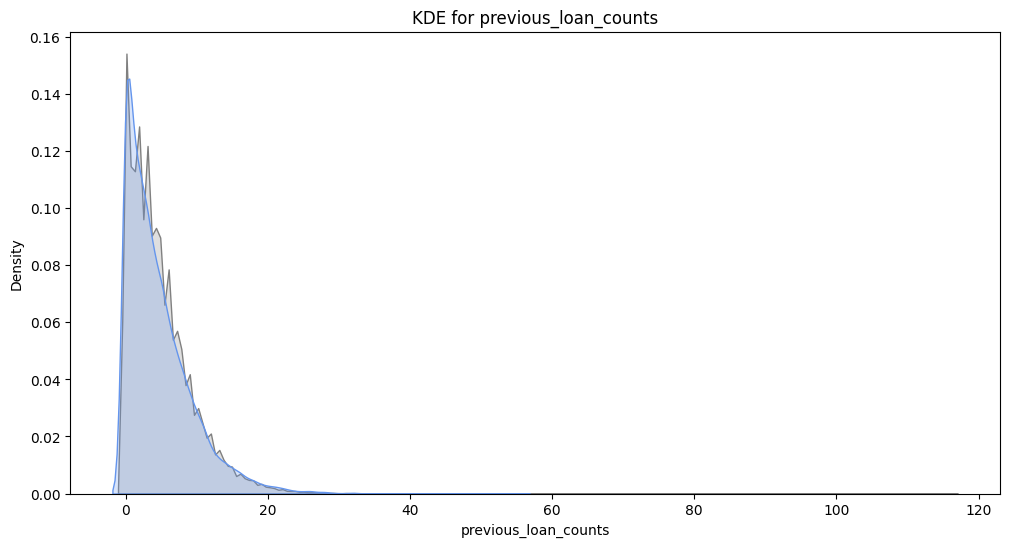

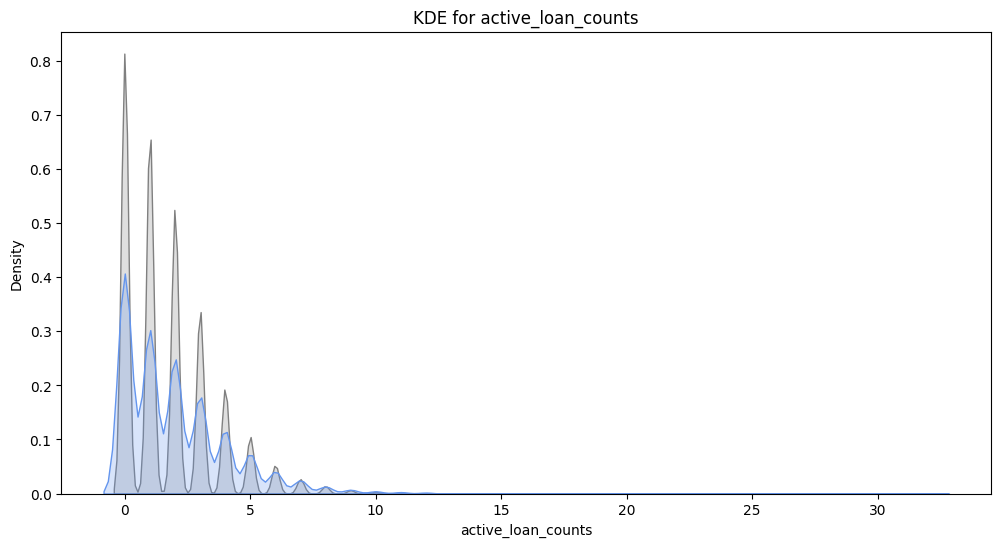

In [96]:
# plot kde of new features
plot_kde(app_train_features, 'previous_loan_counts')
plot_kde(app_train_features, 'active_loan_counts')

In [97]:
print('Training data shape: ', app_train_features.shape)
print('Testing data shape: ', app_test_features.shape)

Training data shape:  (307511, 242)
Testing data shape:  (48744, 241)


Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


<Figure size 1000x1600 with 0 Axes>

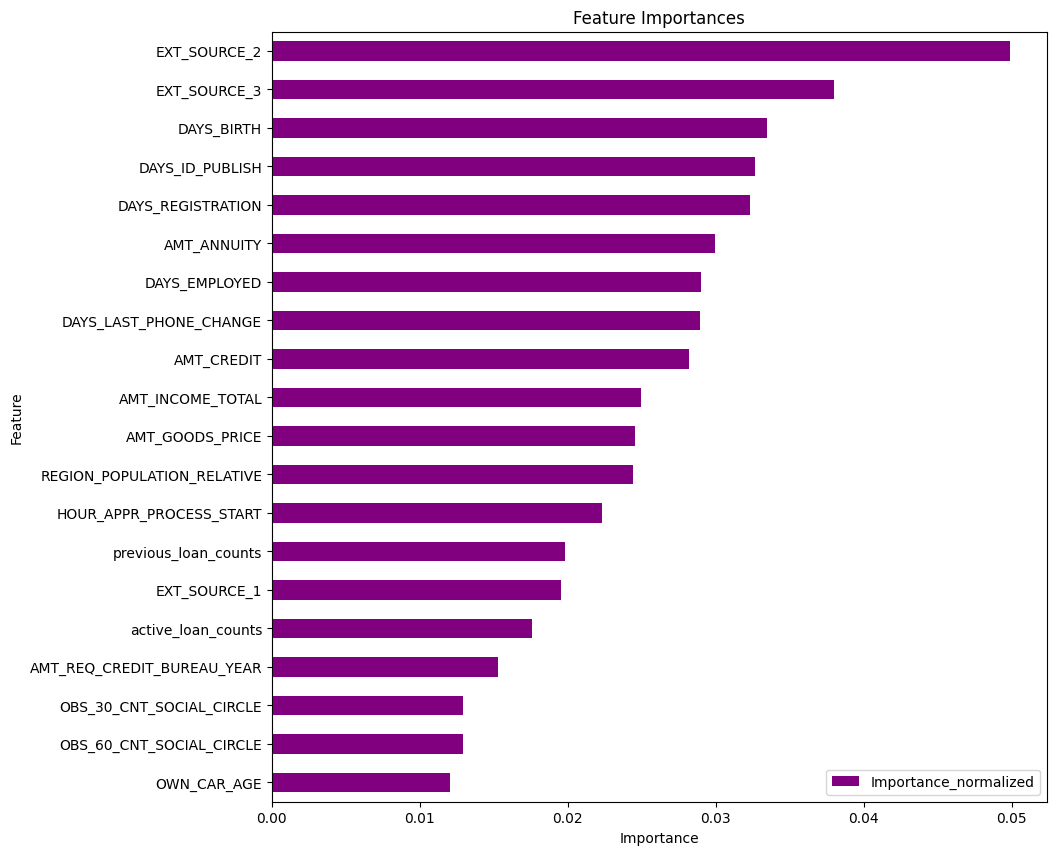

In [98]:
# create X_train, y_train
X_train = app_train_features.drop('TARGET', axis = 1)
y_train = app_train_features['TARGET']
X_test = app_test_features

X_train = X_train.drop('SK_ID_CURR', axis = 1)
X_test = X_test.drop('SK_ID_CURR', axis = 1)

# Feature names
features = list(X_train.columns)

# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(X_train)

# Transform both training and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Repeat with the scaler
scaler.fit(X_train)
train = scaler.transform(X_train)
test = scaler.transform(X_test)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

# Train LR Model
RF = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
RF.fit(X_train,y_train)

# Extract feature importances
feature_importance_values = RF.feature_importances_
feature_importances = pd.DataFrame({'Feature': features, 'Importance': feature_importance_values})

# Make predictions on the test data
predictions = RF.predict_proba(test)[:, 1]

# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_features.csv', index = False)

top20 = plot_feature_importance(feature_importances)

This submission with bureau features added actually underperforms our initial baseline at 0.62242 public and 0.62693 private. 

## <a id='8-2'>8.2 Adding DAYS_CREDIT from Bureau Data</a>

In [99]:
# re-read in bureau data
bureau = pd.read_csv(path + "bureau.csv")
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [100]:
# create feature dataframe
bureau_agg_credit = bureau['SK_ID_CURR'].unique()
bureau_agg_credit = pd.DataFrame(bureau_agg_credit, columns = ['SK_ID_CURR'])
bureau_agg_credit.head()

,SK_ID_CURR
0,215354
1,162297
2,402440
3,238881
4,222183


In [101]:
# average days credit
avg_days_credit = bureau.groupby('SK_ID_CURR', as_index=False)['DAYS_CREDIT'].mean().rename(columns = {'DAYS_CREDIT': 'avg_days_credit'})
avg_days_credit.head()

# join new features
bureau_agg_credit = bureau_agg_credit.merge(avg_days_credit, on = 'SK_ID_CURR', how = 'left')

# fill na
bureau_agg_credit = bureau_agg_credit.fillna(0)
bureau_agg_credit.head()

,SK_ID_CURR,avg_days_credit
0,215354,-727.818182
1,162297,-1344.500000
2,402440,-96.000000
3,238881,-914.750000
4,222183,-959.125000


In [102]:
# join additional features onto train and test
app_train_features = app_train.merge(bureau_agg_credit, on = 'SK_ID_CURR', how = 'left')
app_test_features = app_test.merge(bureau_agg_credit, on = 'SK_ID_CURR', how = 'left')
app_train_features = app_train_features.fillna(0)
app_test_features = app_test_features.fillna(0)

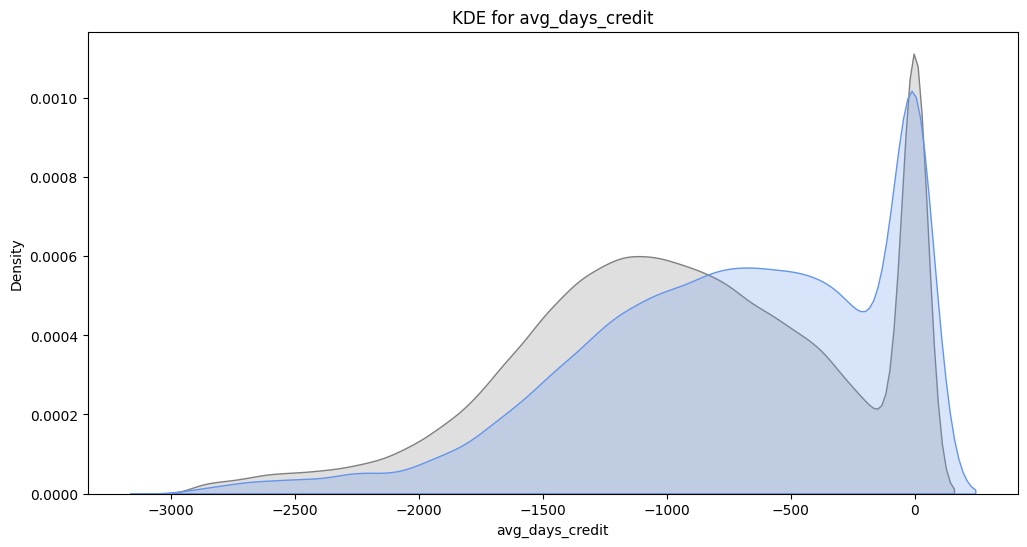

In [103]:
# plot kde of new features
plot_kde(app_train_features, 'avg_days_credit')

In [104]:
print('Training data shape: ', app_train_features.shape)
print('Testing data shape: ', app_test_features.shape)

Training data shape:  (307511, 241)
Testing data shape:  (48744, 240)


Training data shape:  (307511, 239)
Testing data shape:  (48744, 239)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


<Figure size 1000x1600 with 0 Axes>

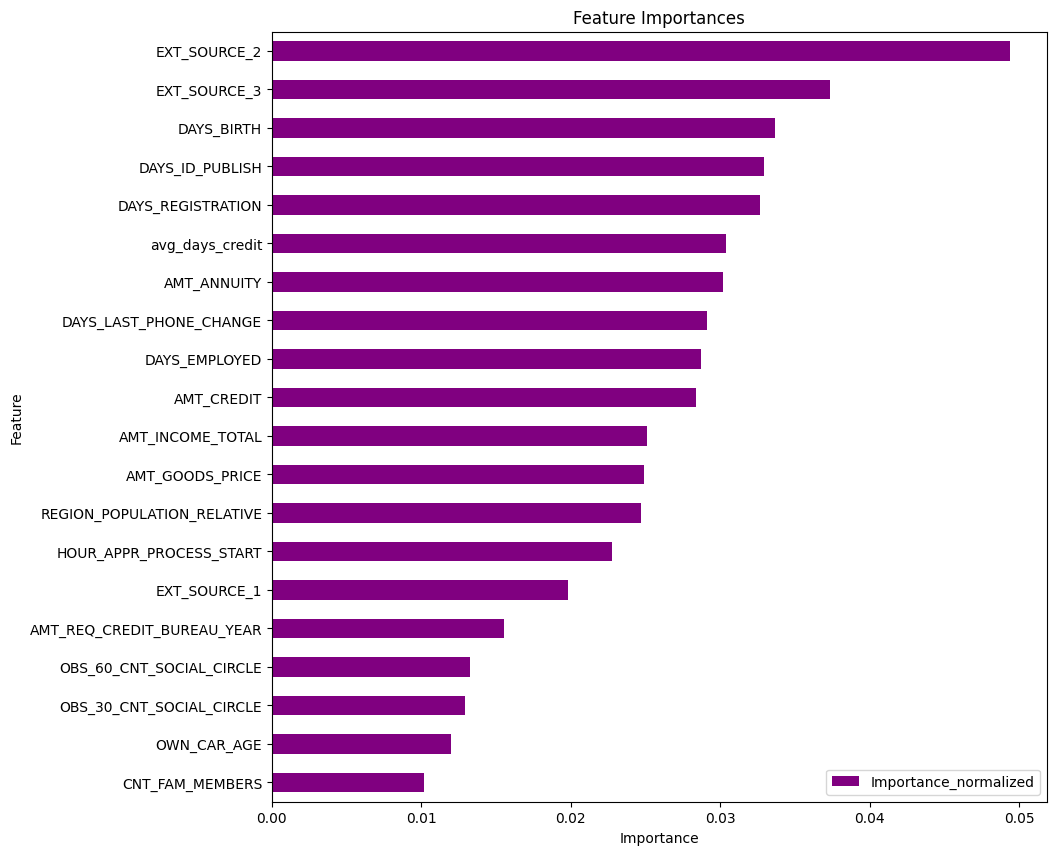

In [105]:
# create X_train, y_train
X_train = app_train_features.drop('TARGET', axis = 1)
y_train = app_train_features['TARGET']
X_test = app_test_features

X_train = X_train.drop('SK_ID_CURR', axis = 1)
X_test = X_test.drop('SK_ID_CURR', axis = 1)

# Feature names
features = list(X_train.columns)

# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(X_train)

# Transform both training and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Repeat with the scaler
scaler.fit(X_train)
train = scaler.transform(X_train)
test = scaler.transform(X_test)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

# Train LR Model
RF = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
RF.fit(X_train,y_train)

# Extract feature importances
feature_importance_values = RF.feature_importances_
feature_importances = pd.DataFrame({'Feature': features, 'Importance': feature_importance_values})

# Make predictions on the test data
predictions = RF.predict_proba(test)[:, 1]

# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_features_days_credit.csv', index = False)

top20 = plot_feature_importance(feature_importances)

This is extremely gratifying--adding in a feature that we determined would be useful from investigation in correlations in the EDA, we have raised our score by over 1% from our initial baseline model to 0.64544 for private and 0.65669 for public.

## <a id='8-3'>8.3 Adding Credit Card Balance Data</a>

In [106]:
# read in credit card balance data
credit_card_balance = pd.read_csv(path + "credit_card_balance.csv")
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [107]:
credit_card_balance.shape

(3840312, 23)

In [108]:
# active loan count
avg_amt = credit_card_balance.groupby('SK_ID_CURR', as_index=False)['AMT_BALANCE'].mean().rename(columns = {'SK_ID_BUREAU': 'avg_amt'})
avg_amt.head()

,SK_ID_CURR,AMT_BALANCE
0,100006,0.000000
1,100011,54482.111149
2,100013,18159.919219
3,100021,0.000000
4,100023,0.000000


In [109]:
avg_amt.shape

(103558, 2)

In [110]:
# create feature dataframe
cc_balance = pd.DataFrame(avg_amt)

In [111]:
# join additional features onto train and test
app_train_features = app_train_features.merge(avg_amt, on = 'SK_ID_CURR', how = 'left')
app_test_features = app_test_features.merge(avg_amt, on = 'SK_ID_CURR', how = 'left')
app_train_features = app_train_features.fillna(0)
app_test_features = app_test_features.fillna(0)

In [112]:
app_train_features.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,avg_days_credit,AMT_BALANCE
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,False,False,False,True,False,True,False,1,-874.00,0.0
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,False,False,False,False,False,True,False,0,-1400.75,0.0
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,False,False,False,False,False,False,False,0,-867.00,0.0
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,False,False,False,False,False,False,False,0,0.00,0.0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,False,False,False,False,False,False,False,0,-1149.00,0.0


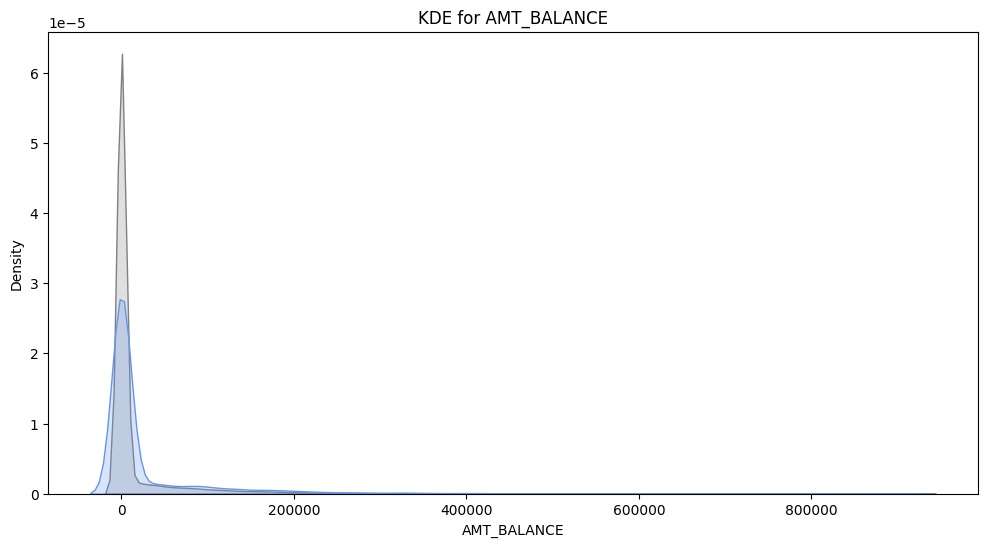

In [113]:
# plot kde of new features
plot_kde(app_train_features, 'AMT_BALANCE')

In [114]:
print('Training data shape: ', app_train_features.shape)
print('Testing data shape: ', app_test_features.shape)

Training data shape:  (307511, 242)
Testing data shape:  (48744, 241)


Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


<Figure size 1000x1600 with 0 Axes>

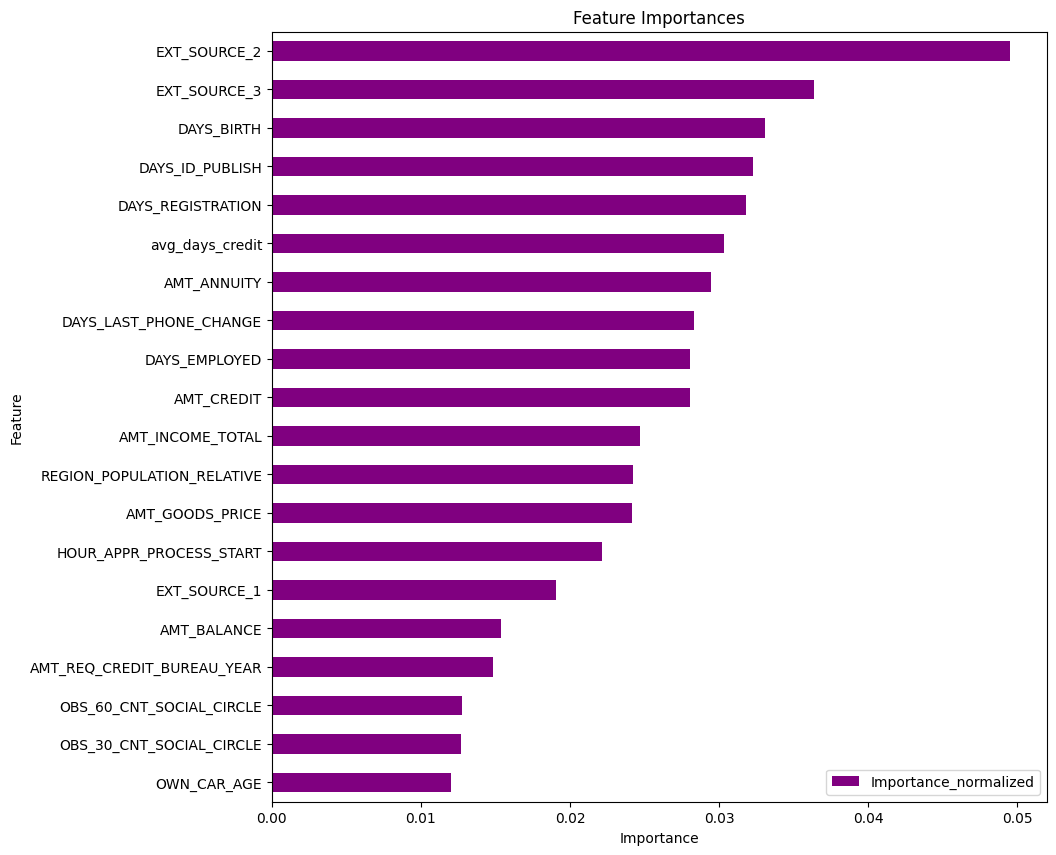

In [115]:
# create X_train, y_train
X_train = app_train_features.drop('TARGET', axis = 1)
y_train = app_train_features['TARGET']
X_test = app_test_features

X_train = X_train.drop('SK_ID_CURR', axis = 1)
X_test = X_test.drop('SK_ID_CURR', axis = 1)

# Feature names
features = list(X_train.columns)

# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(X_train)

# Transform both training and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Repeat with the scaler
scaler.fit(X_train)
train = scaler.transform(X_train)
test = scaler.transform(X_test)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

# Train LR Model
RF = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
RF.fit(X_train,y_train)

# Extract feature importances
feature_importance_values = RF.feature_importances_
feature_importances = pd.DataFrame({'Feature': features, 'Importance': feature_importance_values})

# Make predictions on the test data
predictions = RF.predict_proba(test)[:, 1]

# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_features_bur_cred.csv', index = False)

top20 = plot_feature_importance(feature_importances)

Including the mean of the amt_balance, which is to say the average balance the borrower held month to month actually made the model less accurate. Our private and public ROC / AUC is now 0.63267 and 0.62741, respectively. In part this can be explained by the fact that I took an average of the credit card balance held, which isn't exactly what was being measured when we took the correlaiton in our EDA.

## <a id='8-4'>8.4 Manual Features</a>

In [116]:
app_train['PAYMENT_RATE'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']
app_train['DAYS_EMPLOYED_PERC'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']

In [117]:
# Find the correlation of the positive days since birth and target
app_train['PAYMENT_RATE'] = abs(app_train['PAYMENT_RATE'])
app_train['PAYMENT_RATE'].corr(app_train['TARGET'])

0.012703610951500717

In [118]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_EMPLOYED_PERC'] = abs(app_train['DAYS_EMPLOYED_PERC'])
app_train['DAYS_EMPLOYED_PERC'].corr(app_train['TARGET'])

-0.04448947472079535

In [119]:
app_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,PAYMENT_RATE,DAYS_EMPLOYED_PERC
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,False,False,False,True,False,True,False,1,0.060749,0.067329
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,False,False,False,False,False,True,False,0,0.027598,0.070862
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,False,False,False,False,False,False,False,0,0.050000,0.011814
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,False,False,False,False,False,False,False,0,0.094941,0.159905
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,False,False,False,False,False,False,False,0,0.042623,0.152418


In [120]:
app_test['PAYMENT_RATE'] = app_test['AMT_ANNUITY'] / app_test['AMT_CREDIT']
app_test['DAYS_EMPLOYED_PERC'] = app_test['DAYS_EMPLOYED'] / app_test['DAYS_BIRTH']

In [121]:
app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,PAYMENT_RATE,DAYS_EMPLOYED_PERC
0,100001,0,0,1,0,135000.0,568800.0,20560.5,450000.0,0.018850,...,False,False,False,False,True,False,True,False,0.036147,0.121044
1,100005,0,0,1,0,99000.0,222768.0,17370.0,180000.0,0.035792,...,False,False,False,False,False,False,False,False,0.077973,0.247398
2,100013,0,1,1,0,202500.0,663264.0,69777.0,630000.0,0.019101,...,False,False,False,False,False,False,False,False,0.105202,0.222477
3,100028,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,...,False,False,False,True,False,False,True,False,0.031123,0.133515
4,100038,0,1,0,1,180000.0,625500.0,32067.0,625500.0,0.010032,...,False,False,False,False,False,False,False,False,0.051266,0.168021


In [122]:
bureau = pd.read_csv(path + "bureau.csv")
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [123]:
# create feature dataframe
bureau_agg_credit = bureau['SK_ID_CURR'].unique()
bureau_agg_credit = pd.DataFrame(bureau_agg_credit, columns = ['SK_ID_CURR'])
bureau_agg_credit.head()

,SK_ID_CURR
0,215354
1,162297
2,402440
3,238881
4,222183


In [124]:
# average days credit
avg_days_credit = bureau.groupby('SK_ID_CURR', as_index=False)['DAYS_CREDIT'].mean().rename(columns = {'DAYS_CREDIT': 'avg_days_credit'})
avg_days_credit.head()

# join new features
bureau_agg_credit = bureau_agg_credit.merge(avg_days_credit, on = 'SK_ID_CURR', how = 'left')

# fill na
bureau_agg_credit = bureau_agg_credit.fillna(0)
bureau_agg_credit.head()

,SK_ID_CURR,avg_days_credit
0,215354,-727.818182
1,162297,-1344.500000
2,402440,-96.000000
3,238881,-914.750000
4,222183,-959.125000


In [125]:
# join additional features onto train and test
app_train_features = app_train.merge(bureau_agg_credit, on = 'SK_ID_CURR', how = 'left')
app_test_features = app_test.merge(bureau_agg_credit, on = 'SK_ID_CURR', how = 'left')
app_train_features = app_train_features.fillna(0)
app_test_features = app_test_features.fillna(0)

In [126]:
print('Training data shape: ', app_train_features.shape)
print('Testing data shape: ', app_test_features.shape)

Training data shape:  (307511, 243)
Testing data shape:  (48744, 242)


Training data shape:  (307511, 241)
Testing data shape:  (48744, 241)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


<Figure size 1000x1600 with 0 Axes>

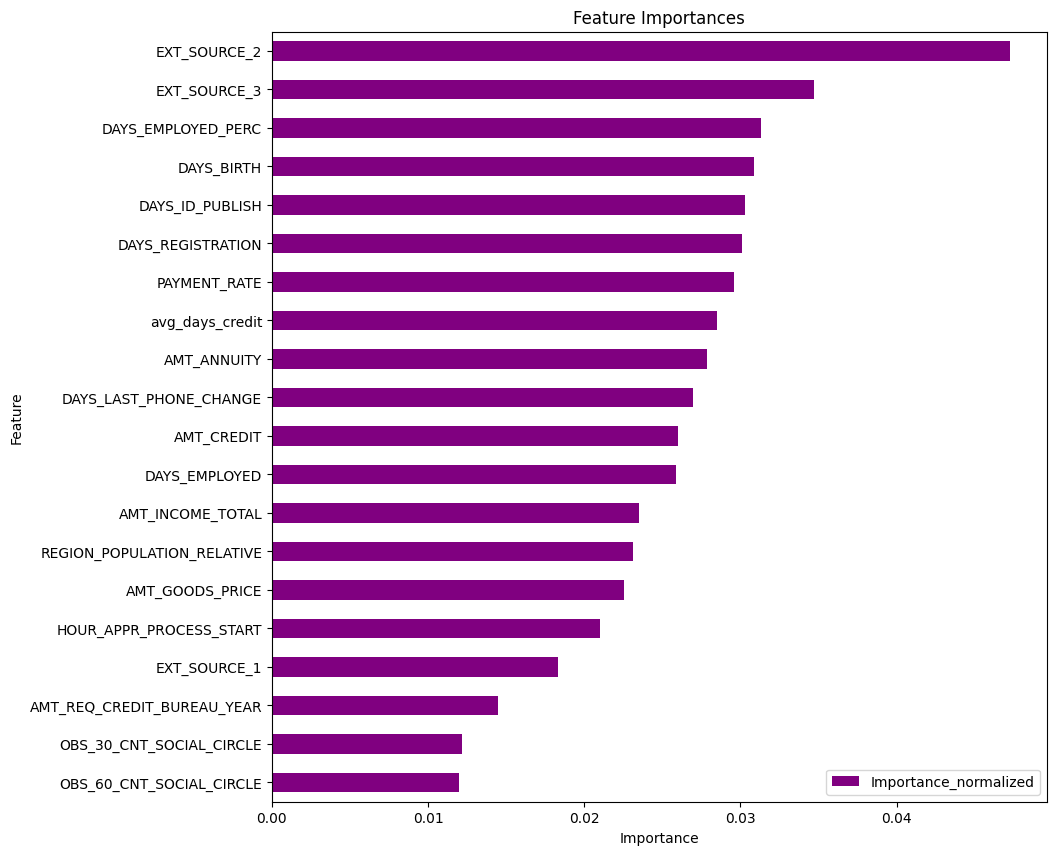

In [127]:
# create X_train, y_train
X_train = app_train_features.drop('TARGET', axis = 1)
y_train = app_train_features['TARGET']
X_test = app_test_features

X_train = X_train.drop('SK_ID_CURR', axis = 1)
X_test = X_test.drop('SK_ID_CURR', axis = 1)

# Feature names
features = list(X_train.columns)

# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(X_train)

# Transform both training and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Repeat with the scaler
scaler.fit(X_train)
train = scaler.transform(X_train)
test = scaler.transform(X_test)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

# Train LR Model
RF = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
RF.fit(X_train,y_train)

# Extract feature importances
feature_importance_values = RF.feature_importances_
feature_importances = pd.DataFrame({'Feature': features, 'Importance': feature_importance_values})

# Make predictions on the test data
predictions = RF.predict_proba(test)[:, 1]

# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_best_features.csv', index = False)

top20 = plot_feature_importance(feature_importances)

# <a id='9'>9. LightGB Model</a>

Finally, I would not want to leave out gradient booseted machines. These models tend to perform very well in competitions.

In [128]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [129]:
submission, fi, metrics = model(app_train_features, app_test_features)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (307511, 241)
Testing Data Shape:  (48744, 241)
[200]	train's auc: 0.803162	train's binary_logloss: 0.543393	valid's auc: 0.761653	valid's binary_logloss: 0.558816
[400]	train's auc: 0.832149	train's binary_logloss: 0.513781	valid's auc: 0.761883	valid's binary_logloss: 0.541022
[200]	train's auc: 0.802745	train's binary_logloss: 0.543887	valid's auc: 0.765246	valid's binary_logloss: 0.559327
[400]	train's auc: 0.83178	train's binary_logloss: 0.514024	valid's auc: 0.766246	valid's binary_logloss: 0.541091
[200]	train's auc: 0.801909	train's binary_logloss: 0.54515	valid's auc: 0.769642	valid's binary_logloss: 0.559979
[200]	train's auc: 0.803556	train's binary_logloss: 0.543393	valid's auc: 0.765896	valid's binary_logloss: 0.557601
[200]	train's auc: 0.803088	train's binary_logloss: 0.543643	valid's auc: 0.764854	valid's binary_logloss: 0.560056
Baseline metrics
      fold     train     valid
0        0  0.821358  0.762186
1        1  0.831387  0.766269
2        2

In [130]:
def plot_feature_importances(df, num_bars = 15):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """

    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:num_bars]))), 
            df['importance_normalized'].head(num_bars), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:num_bars]))))
    ax.set_yticklabels(df['feature'].head(num_bars))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

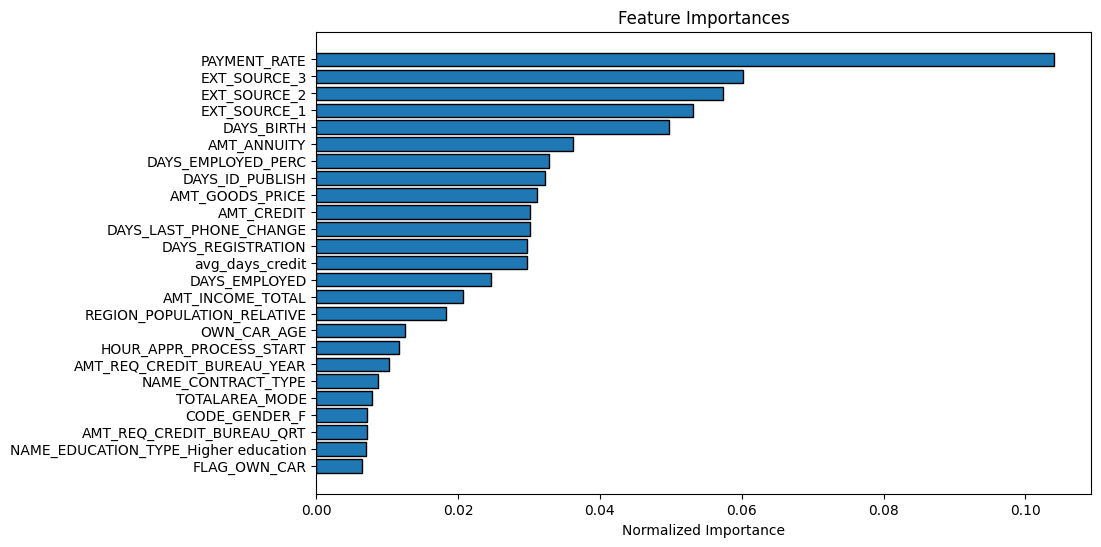

In [131]:
fi_sorted = plot_feature_importances(fi, 25)

In [132]:
submission.to_csv('baseline_lgb_features.csv', index = False)

In [133]:
! jupyter nbconvert modeling.ipynb --to html_toc --TagRemovePreprocessor.remove_cell_tags='{"hide_code"}'

[NbConvertApp] Converting notebook modeling.ipynb to html_toc
[NbConvertApp] Writing 1495224 bytes to modeling.html
